In [ ]:
!git clone https://github.com/AhMuGeoNa/2022-AI-Competition.git

Cloning into '2022-AI-Competition'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 53 (delta 9), reused 25 (delta 2), pack-reused 0
Unpacking objects: 100% (53/53), done.


In [ ]:
!cp -r 2022-AI-Competition/data data
!mkdir data/csv
!mkdir data/zips
!cp -r "drive/MyDrive/Colab Notebooks/dataset/zips/train.zip" data/train.zip

In [ ]:
!mv data/train.csv data/csv/train.csv
!mv data/test.csv data/csv/test.csv
!mv data/valid.csv data/csv/valid.csv
!mv data/train.zip data/zips/train.zip

!unzip data/zips/train.zip -d data

In [121]:
## 데이터 처리에 필요한 패키지 로드
from imutils.paths import list_images
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import cv2, os
import shutil

# **1.데이터셋 전처리**
- 전체 이미지 데이터 셋 10,000장
- 학습 : 시험 : 검증 = 6 : 2 : 2로 분할
- 이미지 중에서 어두운 이미지가 존재하여 이미지 평탄화 진행

In [122]:
images_path = 'data/images'
csv_path    = 'data/csv'

## csv 파일에 존재하는 정보들을 기반으로하여 라벨별로 데이터 정리하는 함수
def data_organizer(dtype = 'train'):
  df = pd.read_csv(f'{csv_path}/{dtype}.csv')

  for image_path, grade in zip(df['imname'], df['grade']):
    os.makedirs(f'data/{dtype}/{grade}', exist_ok = True)
    shutil.copy(f'{images_path}/{image_path}', f'data/{dtype}/{grade}/{image_path}')

data_organizer()
data_organizer(dtype = 'test')
data_organizer(dtype = 'valid')

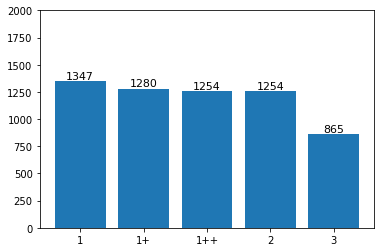

In [123]:
## 데이터 분포 확인하는 함수
def data_distribution(data_path):
  ## data_path에 있는 이미지 목록을 리스트로 불러오는 부분.
  image_paths = sorted(list_images(data_path))

  ## 이미지 경로에서 '/'을 기준으로 나눈것 중 마지막에서 2번째 값만 가져옴. (라벨값만 가져옴.)
  ## (e.g.) data/train/1++/cow_1++_1002.jpg => 1++
  image_paths = [image_path.split(os.path.sep)[-2] for image_path in image_paths]

  ## 라벨별 개수를 반환해주는 부분 (딕셔너리 형태로 만들어짐)
  label_count = Counter(image_paths)
  label_count = dict(sorted(label_count.items()))

  ## 레이블 별 데이터 분포를 시각화 시키는 코드
  plt.bar(label_count.keys(), label_count.values())
  plt.ylim(0, 2000)

  for grade, num in label_count.items():
      plt.text(
                  grade, num, num,
                  fontsize = 11, color = 'black',
                  horizontalalignment = 'center',
                  verticalalignment = 'bottom'
              )
  plt.show()

## 3등급 이미지가 다른 이미지들에 비해 수가 적은 것을 보임.
## 일단 그냥 한 번 돌려보고 성능이 제대로 나오지 않을 경우에 불균형 해소후 학습
data_distribution('data/train')

In [124]:
## 라벨을 인덱스 값으로 변경
label2idx = {'1++' : 0, '1+' : 1, '1' :2, '2' :3, '3': 4}
idx2label = {idx : lb for lb, idx in label2idx.items()}

print(label2idx)
print(idx2label)

{'1++': 0, '1+': 1, '1': 2, '2': 3, '3': 4}
{0: '1++', 1: '1+', 2: '1', 3: '2', 4: '3'}


In [125]:
## 이미지 전처리 해주는 함수
def preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    ycrcb_planes = list(cv2.split(image))


    # 밝기 성분에 대해서만 히스토그램 평활화 수행
    ycrcb_planes[0] = cv2.equalizeHist(ycrcb_planes[0])

    image = cv2.merge(ycrcb_planes)
    image = cv2.cvtColor(image, cv2.COLOR_YCrCb2RGB)

    return image

datasets = {}
## 전처리한 이미지를 넘파이 배열로 만들어주는 함수
def buid_dataset(data_path, dtype = 'train'):
  image_paths = sorted(list_images(data_path))

  images, labels = [], []
  for image_path in image_paths:

    image = cv2.imread(image_path)
    image = preprocessing(image)
    image = cv2.resize(image, (240, 240))
    
    images.append(image)
    labels.append(label2idx[image_path.split(os.path.sep)[-2]])

  datasets[dtype] = [np.array(images), np.array(labels)]
  return datasets

datasets = buid_dataset('data/train')
datasets = buid_dataset('data/test', dtype = 'test')
datasets = buid_dataset('data/valid', dtype = 'valid')

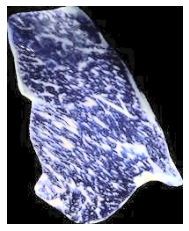

In [126]:
## 원본 이미지
image = cv2.imread('data/train/1++/cow_1++_1074.jpg')
plt.axis(False)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

## 전처리한 이미지
image = preprocessing(image)

plt.axis(False)
plt.imshow(image)

# **2. 학습 진행하기**
## **2-1. 데이터 셋 구성하기**

In [ ]:
## 사전 학습된 모델을 불러오는 패키지
!pip install timm

In [128]:
## 신경망 구성에 필요한 패키지 로드
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import Adam, AdamW
from torchvision import transforms
import torch.nn.functional as F
from torchvision import utils
import torch.nn as nn
import easydict
import torch
import timm
import gc

In [130]:
NUM_CLASSES     = 5
SEED            = 99
DEVICE          = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_WORKERS     = 1
PIN_MEMORY      = True

HIDDEN_DIMS     = 128
DROPOUT_RATE    = 0.1

EPOCHS          = 100
BATCH_SIZE      = 32
LR              = 5e-4
CLIP_GRAD       = 10
PATIENCE        = 5

In [140]:
## 커스텀 데이터셋 생성
class BeafData(Dataset):

  def __init__(self, images, labels, dtype = 'train'):

    self.images = images
    self.labels = labels
    self.dtype  = dtype
    
    self.transform = {}
    self.transform['train'] = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomVerticalFlip(),
                                    transforms.ToTensor()             
                              ])
    self.transform['test'] = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.ToTensor()             
                          ])

    self.transform['valid'] = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.ToTensor()             
                      ])

    self.num_datas = self.labels.shape[0]

  ## 이미지, 라벨 데이터를 튜플형태로 변환
  def __getitem__(self, index):
    image = self.images[index].reshape(240, 240, 3)

    image = self.transform[self.dtype](image)
    return image, self.labels[index]

  def __len__(self):
    return self.num_datas

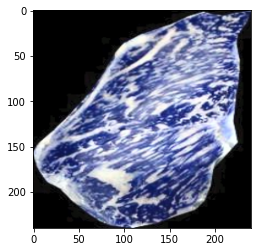

In [141]:
train_images, train_labels = datasets['train']
train_dataset              = BeafData(train_images, train_labels)
train_loader               = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

plt.imshow(train_images[0])

In [142]:
valid_images, valid_labels = datasets['valid']
valid_dataset             = BeafData(valid_images, valid_labels, dtype = 'valid')
valid_loader              = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = False)

torch.Size([3, 240, 240])


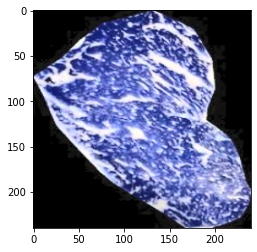

In [143]:
data_iter = iter(train_loader)

images, labels = next(data_iter)
image = images[0]

print(image.shape)
plt.imshow(np.transpose(image, (1, 2, 0)))

torch.Size([3, 240, 240])


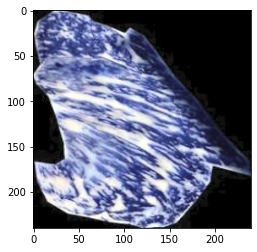

In [144]:
data_iter = iter(valid_loader)

images, labels = next(data_iter)
image = images[0]

print(image.shape)
plt.imshow(np.transpose(image, (1, 2, 0)))

## **2-2. 신경망 구성하기**
- timm을 이용한 사전 학습모델 사용하여 신경망 구성
- 이미지 데이터가 248 x 200 이미지 이므로,   
  사전 학습 모델의 입력 사이즈가 240 x 240인 것으로 테스트 해보기

In [145]:
## efficientnet 목록
timm.list_models('*efficientnet*')

['efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b1_pruned',
 'efficientnet_b2',
 'efficientnet_b2_pruned',
 'efficientnet_b2a',
 'efficientnet_b3',
 'efficientnet_b3_pruned',
 'efficientnet_b3a',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_b8',
 'efficientnet_cc_b0_4e',
 'efficientnet_cc_b0_8e',
 'efficientnet_cc_b1_8e',
 'efficientnet_el',
 'efficientnet_el_pruned',
 'efficientnet_em',
 'efficientnet_es',
 'efficientnet_es_pruned',
 'efficientnet_l2',
 'efficientnet_lite0',
 'efficientnet_lite1',
 'efficientnet_lite2',
 'efficientnet_lite3',
 'efficientnet_lite4',
 'efficientnetv2_l',
 'efficientnetv2_m',
 'efficientnetv2_rw_m',
 'efficientnetv2_rw_s',
 'efficientnetv2_rw_t',
 'efficientnetv2_s',
 'efficientnetv2_xl',
 'gc_efficientnetv2_rw_t',
 'tf_efficientnet_b0',
 'tf_efficientnet_b0_ap',
 'tf_efficientnet_b0_ns',
 'tf_efficientnet_b1',
 'tf_efficientnet_b1_ap',
 'tf_efficientnet_b1_ns',
 'tf_efficientnet_b2',
 'tf_efficien

In [146]:
 ## 신경망 fine-tunning
class EffNet(nn.Module):
  def __init__(self,num_classes):
    super().__init__()
    self.model = timm.create_model('efficientnet_b1', pretrained = True,
                                   num_classes = num_classes)
    
  def forward(self, x):
    output = self.model(x)
    return output

In [147]:
## 손실함수 정의
criterion = nn.CrossEntropyLoss()

## 최적화 함수 가져오는 함수
def get_optim(model):
  optim = AdamW(model.parameters(), lr = LR, weight_decay = 0.0)

  ## 모든 파라미터들의 grad값을 0으로 초기화
  optim.zero_grad()
  return optim

## 러닝레이트 스케줄러함수
def get_scheduler(optim):
  scheduler = ReduceLROnPlateau(optim, patience = PATIENCE, factor = 0.5,
                                mode = 'max', verbose = True)
  return scheduler

## 학습 함수
def train(model, train_loader, optim):
  model.train()
  corrects, total_loss = 0, 0
 
  for (images, labels) in train_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

    optim.step()
    optim.zero_grad()

    _, preds = torch.max(outputs, 1)
    corrects += torch.sum(preds == labels.data)
    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  acc = corrects / (len(train_loader)*BATCH_SIZE)

  print(f'Train Accuracy : {acc:.3f} | Train Loss : {avg_loss:.3f}')
  return acc

## 검증 함수
def validation(model, valid_loader):
  model.eval()
  corrects, total_loss = 0, 0

  for (images, labels) in valid_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)
    loss = criterion(outputs, labels)

    _, preds = torch.max(outputs, 1)
    corrects += torch.sum(preds == labels.data)
    total_loss += loss.item()

  avg_loss = total_loss / len(valid_loader)
  acc = corrects / (len(valid_loader)*BATCH_SIZE)
  print(f'Valid Accuracy : {acc:.3f} | Valid Loss : {avg_loss:.3f}\n')

  return acc, outputs

In [148]:
## 훈련 사이클 함수
def run(model, train_loader, valid_loader):
  
  ## 캐시 메모리 비우기 및 가비지 컬렉터 실행
  ## 모델 여러번 학습시키고 나면 메모리에 남는 찌꺼기들 제거해주는 코드
  torch.cuda.empty_cache()
  gc.collect()

  optim     = get_optim(model)
  scheduler = get_scheduler(optim)

  early_stopping_counter = 0
  best_acc               = -1

  for epoch in range(EPOCHS):
    print(f'[{epoch + 1} / {EPOCHS}]')

    train_acc          = train(model, train_loader, optim)
    valid_acc, outputs = validation(model, valid_loader)

    if valid_acc > best_acc:
      best_acc               = valid_acc
      early_stopping_counter = 0

    else:
      early_stopping_counter += 1
      if early_stopping_counter >= PATIENCE:
        print(f'Early stopping counter : {early_stopping_counter}')
        break

    scheduler.step(best_acc)

In [149]:
model = EffNet(num_classes = NUM_CLASSES)
model.to(DEVICE)

run(model, train_loader, valid_loader)

[1 / 100]
Train Accuracy : 0.382 | Train Loss : 1.691
Valid Accuracy : 0.434 | Valid Loss : 1.236

[2 / 100]
Train Accuracy : 0.524 | Train Loss : 1.106
Valid Accuracy : 0.483 | Valid Loss : 1.185

[3 / 100]
Train Accuracy : 0.630 | Train Loss : 0.908
Valid Accuracy : 0.521 | Valid Loss : 1.135

[4 / 100]
Train Accuracy : 0.722 | Train Loss : 0.722
Valid Accuracy : 0.572 | Valid Loss : 1.151

[5 / 100]
Train Accuracy : 0.797 | Train Loss : 0.525
Valid Accuracy : 0.607 | Valid Loss : 1.140

[6 / 100]
Train Accuracy : 0.848 | Train Loss : 0.401
Valid Accuracy : 0.624 | Valid Loss : 1.163

[7 / 100]
Train Accuracy : 0.868 | Train Loss : 0.353
Valid Accuracy : 0.647 | Valid Loss : 1.048

[8 / 100]
Train Accuracy : 0.913 | Train Loss : 0.230
Valid Accuracy : 0.647 | Valid Loss : 1.283

[9 / 100]
Train Accuracy : 0.917 | Train Loss : 0.224
Valid Accuracy : 0.649 | Valid Loss : 1.234

[10 / 100]
Train Accuracy : 0.938 | Train Loss : 0.169
Valid Accuracy : 0.673 | Valid Loss : 1.146

[11 / 100

In [ ]:
 from sklearn.metrics import classification_report

In [150]:
test_images, test_labels = datasets['test']
test_dataset              = BeafData(test_images, test_labels)
test_loader               = DataLoader(test_dataset, batch_size = 1, shuffle = True)


In [151]:
## 성능 지표 계산함수
def evaluation(model, test_loader):
  model.eval()
  corrects = 0
  preds, gt = [], []

  for images, labels in test_loader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    outputs = model(images)

    _, pred = torch.max(outputs, 1)
    corrects += torch.sum(pred == labels.data)

    preds.append(pred.item())
    gt.append(labels.data.item())

  acc = corrects / len(test_loader)
  print(f'Test Accuracy : {acc:.3f}\n')

  return classification_report(gt, preds, target_names = label2idx.keys())

report = evaluation(model, test_loader)
print(report)

Test Accuracy : 0.712

              precision    recall  f1-score   support

         1++       0.72      0.63      0.67       440
          1+       0.55      0.73      0.63       427
           1       0.71      0.62      0.66       427
           2       0.78      0.74      0.76       418
           3       0.94      0.91      0.92       288

    accuracy                           0.71      2000
   macro avg       0.74      0.73      0.73      2000
weighted avg       0.72      0.71      0.71      2000

